In [6]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import pickle
from matplotlib.path import Path
import matplotlib.pyplot as plt
from skimage.draw import polygon2mask



# Figure 3I
Generate random shapes, and compare intersection rates and circularity of shape.

In [ ]:
def random_point_in_circle(radius):
    # Random direction (unit vector)
    direction = np.random.normal(size=2)
    direction /= np.linalg.norm(direction)
    # Random radius, scaled to preserve uniform volume density
    r = np.random.random() ** (1/2) * radius
    return direction * r

def is_cutoff(contour, grid_size):
    rows, cols = contour[:, 0], contour[:, 1]
    return np.any(rows <= 1) or np.any(rows >= grid_size - 2) or np.any(cols <= 1) or np.any(cols >= grid_size - 2)

def polygon_area(x, y):
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def polygon_perimeter(x, y):
    dx = np.diff(x, append=x[0])
    dy = np.diff(y, append=y[0])
    return np.sum(np.hypot(dx, dy))
def min_distance(x, y):

    # Stack points for easier computation
    points = np.column_stack((x, y))
    
    # Compute centroid
    center = points.mean(axis=0)
    
    # Compute distances from centroid to all points
    distances = np.linalg.norm(points - center, axis=1)
    
    # Find minimum distance
    min_dist = np.min(distances)
    
    return min_dist

def generate_closed_random_shape(target_area=10, grid_size=500, sigma=3, level=0.7):
    field = np.random.randn(grid_size, grid_size)
    field = gaussian_filter(field, sigma=sigma)
    field -= field.min()
    field /= field.max()

    contours = find_contours(field, level=level)
    valid_contours = [c for c in contours if not is_cutoff(c, grid_size)]
    if not valid_contours:
        return None, None, None  # Failed


    contour = max(valid_contours, key=len)
    x, y = contour[:, 1], contour[:, 0]

    if not np.allclose([x[0], y[0]], [x[-1], y[-1]]):
        x = np.append(x, x[0])
        y = np.append(y, y[0])

    current_area = polygon_area(x, y)
    if current_area <= 0:
        return None, None, None

    scale = np.sqrt(target_area / current_area)
    x *= scale
    y *= scale

    return x, y, (polygon_area(x, y)*4*np.pi)/(polygon_perimeter(x, y)**2)


def sample_intersections_perimeter_only(x, y, base_radius=300, n_samples=1000):
    # Center the shape
    mindist = min_distance(x, y)
    intersections = 0
    for _ in range(n_samples):
        while True:
            center1,center2 = random_point_in_circle(base_radius-mindist)
            x_centered = x + (center1 - np.mean(x))
            y_centered = y + (center2 - np.mean(y))
            if np.all(np.linalg.norm(np.column_stack((x_centered, y_centered)), axis=1) <= base_radius):
                shape_polygon = Polygon(np.column_stack((x_centered, y_centered)))
                break
        sample_radius = np.random.uniform(1, base_radius)

        # Compute max distance from center to keep circle fully inside the base_radius region
        max_offset = base_radius - sample_radius

        # Random angle and distance for center placement
        px, py = random_point_in_circle(np.random.uniform(0,max_offset)) 

        # Generate perimeter points
        n_points = int(2 * np.pi * sample_radius)
        angles = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
        x_perim = px + sample_radius * np.cos(angles)
        y_perim = py + sample_radius * np.sin(angles)

        # Ensure closed loop
        coords = np.column_stack((x_perim, y_perim))
        coords = np.vstack([coords, coords[0]])

        circle_perimeter = LineString(coords)

        if shape_polygon.intersects(circle_perimeter):
            intersections += 1

    return intersections / n_samples



def one_simulation(seed=10):
    if seed is not None:
        np.random.seed(seed)
    try:
        x, y, circ = generate_closed_random_shape(target_area=1112)
        if x is None:
            return None
        intersection_ratio = sample_intersections_perimeter_only(x, y, n_samples=10000)
        return circ, intersection_ratio, x,y
    except:
        return None

# # --- Run in parallel ---
n_runs = 10000
n_workers = 8

with ProcessPoolExecutor(max_workers=n_workers) as executor:
    results = list(tqdm(executor.map(one_simulation, range(n_runs)), total=n_runs))

# Filter out failed runs
filtered = [res for res in results if res is not None]
circularities, intersection_ratios, all_xs, all_ys = zip(*filtered)


# # --- Output or use data ---
print(f"Completed {len(filtered)} successful simulations out of {n_runs}")
print("Example:")
print(f"  Circularity (first 5): {circularities[:5]}")
print(f"  Intersection Ratios (first 5): {intersection_ratios[:5]}")

In [ ]:
with open("shapes_data_mov_cent.pkl", "wb") as f:
    pickle.dump({'circularities': circularities,
                 'intersection_ratios': intersection_ratios,
                 'x_coords': all_xs,
                 'y_coords': all_ys}, f)
with open("shapes_data_mov_cent.pkl", "rb") as f:
    data = pickle.load(f)

# Unpack the data
circularities = data['circularities']
intersection_ratios = data['intersection_ratios']
all_xs = data['x_coords']
all_ys = data['y_coords']


9998


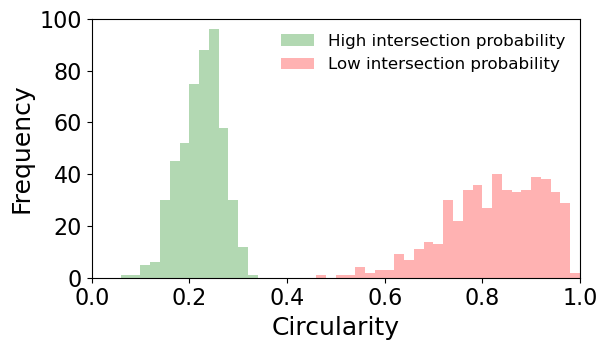

In [32]:
pd.DataFrame({'circularity': circularities, 'intersection_ratios': intersection_ratios}).to_excel("shape_results_mov_cent.xlsx", index=False)
df = pd.read_excel("shape_results_mov_cent.xlsx")
n_runs = 10000
top_inter = df.sort_values(by='intersection_ratios', ascending=False).head(int(n_runs*0.05))
bottom_inter = df.sort_values(by='intersection_ratios', ascending=True).head(int(n_runs*0.05))
print(len(df))
# Plotting
bins = np.linspace(0, 1, 51)
plt.figure(figsize=(6, 3.6))
plt.hist(top_inter['circularity'], bins=bins, alpha=0.3, label=f'High intersection probability', color='green')
plt.hist(bottom_inter['circularity'], bins=bins, alpha=0.3, label=f'Low intersection probability', color='red')
plt.xlabel('Circularity', fontsize = 18)
plt.ylabel('Frequency', fontsize =18)
plt.ylim(0,100)
plt.legend(fontsize =12,frameon=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.xlim(0,1)
plt.savefig("Images_for_paper/fig3_distribution_mov_cent.png")
plt.show()


# Figure 3 G,H

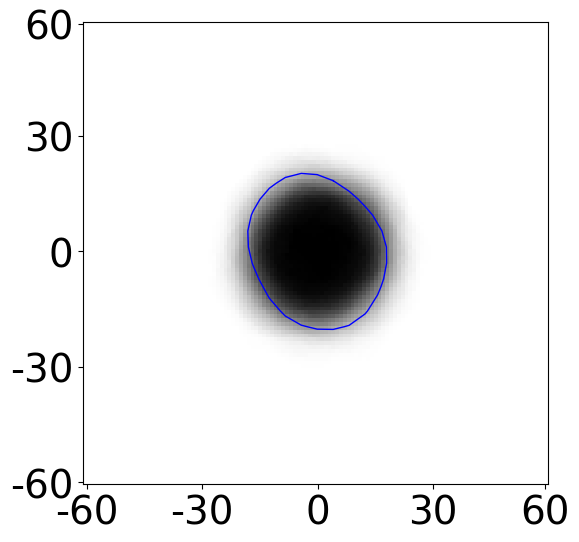

In [34]:

# Lowest intersection shapes
sorted_indices = np.argsort(intersection_ratios)
selected_indices = sorted_indices[:int(n_runs*0.05)] 

# Accumulate masks
accumulated_mask = np.zeros((grid_size, grid_size), dtype=np.uint32)

for idx in selected_indices:
    x_c, y_c = center_shape(all_xs[idx], all_ys[idx], *target_center)
    mask = rasterize_shape(x_c, y_c, grid_size)
    accumulated_mask += mask
# Overlay one selected shape (e.g., the one with the lowest intersection)
highlight_idx = selected_indices[0]  # or any other index you want
x_c, y_c = center_shape(all_xs[highlight_idx], all_ys[highlight_idx], *target_center)


# Normalize and contour the overlap map
plt.figure(figsize=(6, 6))
plt.plot(x_c, y_c, color='blue', linewidth=1, label='Highlighted Shape')
plt.imshow(accumulated_mask, cmap='binary', origin='lower')
plt.xticks([0, 30,60, 90,119],[-60,-30,0, 30,60])
plt.yticks([0, 30,60, 90,119],[-60,-30,0, 30,60])
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig("Images_for_paper/fig3_lowint_contour_mov_cent.png")
plt.axis("equal")
plt.show()

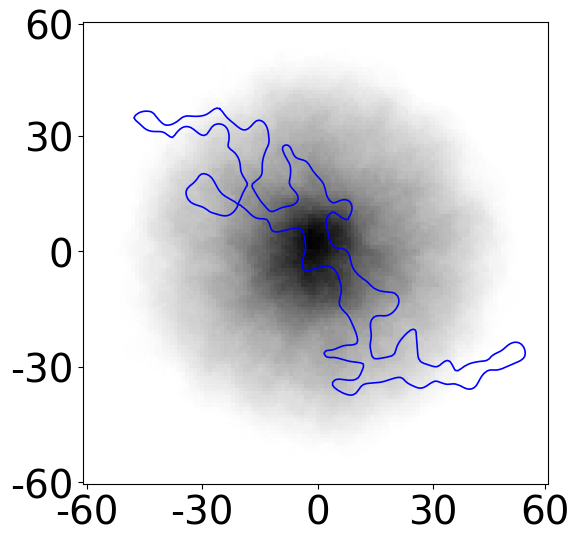

In [33]:
n_runs = 10000
grid_size = 120
target_center = (60, 60)

def center_shape(x, y, target_x=200, target_y=200):
    cx, cy = np.mean(x), np.mean(y)
    return x - cx + target_x, y - cy + target_y

def rasterize_shape(x, y, grid_size):
    mask = np.zeros((grid_size, grid_size), dtype=np.uint32)
    path = Path(np.vstack((x, y)).T)
    yy, xx = np.meshgrid(np.arange(grid_size), np.arange(grid_size), indexing='ij')
    points = np.vstack((xx.ravel(), yy.ravel())).T
    mask[path.contains_points(points).reshape(grid_size, grid_size)] = 1
    return mask

# Select top 5 highest or lowest intersection shapes
sorted_indices = np.argsort(intersection_ratios)
selected_indices = sorted_indices[-int(n_runs*0.05):]  # or [:5] for lowest

highlight_idx = selected_indices[0]  # or any other index you want
x_c, y_c = center_shape(all_xs[highlight_idx], all_ys[highlight_idx], *target_center)

# Accumulate masks
accumulated_mask = np.zeros((grid_size, grid_size), dtype=np.uint32)

for idx in selected_indices:
    x_c, y_c = center_shape(all_xs[idx], all_ys[idx], *target_center)
    mask = rasterize_shape(x_c, y_c, grid_size)
    accumulated_mask += mask

# Normalize and contour the overlap map
plt.figure(figsize=(6, 6), facecolor='white')
plt.plot(x_c, y_c, color='blue', linewidth=1.2, label='Highlighted Shape')
plt.imshow(accumulated_mask, cmap='binary', origin='lower') 
plt.xticks([0, 30,60, 90,119],[-60,-30,0, 30,60])
plt.yticks([0, 30,60, 90,119],[-60,-30,0, 30,60])
plt.axis("equal")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig("fig3H.png")
plt.show()


# Supplementary figure 1

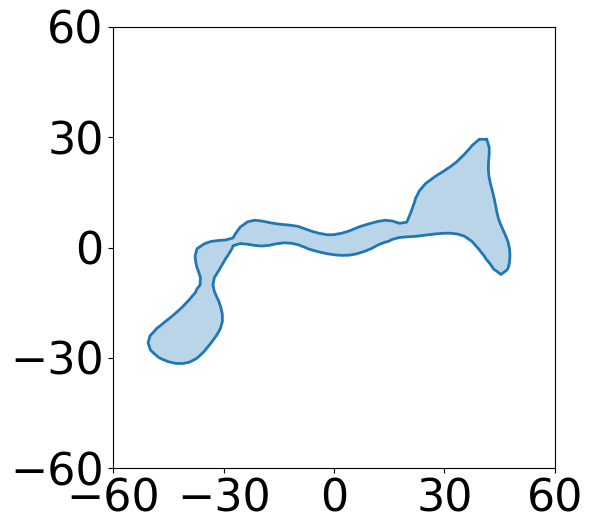

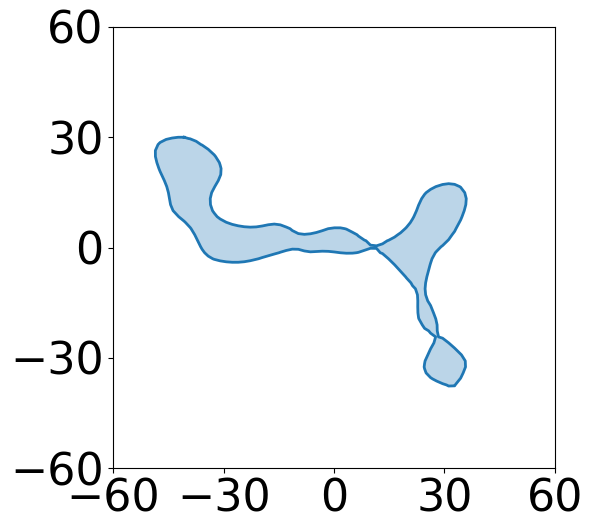

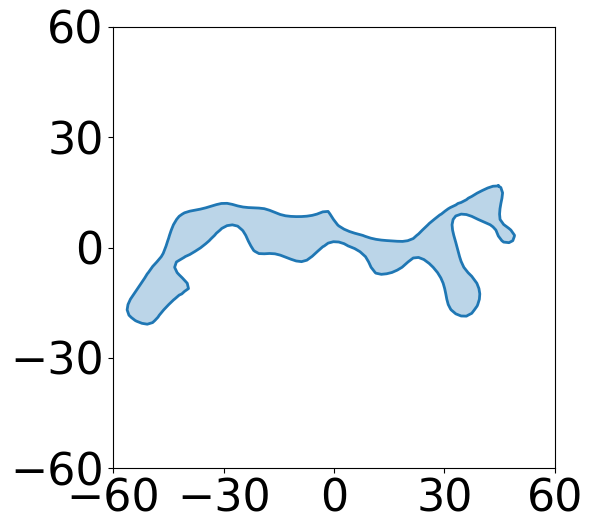

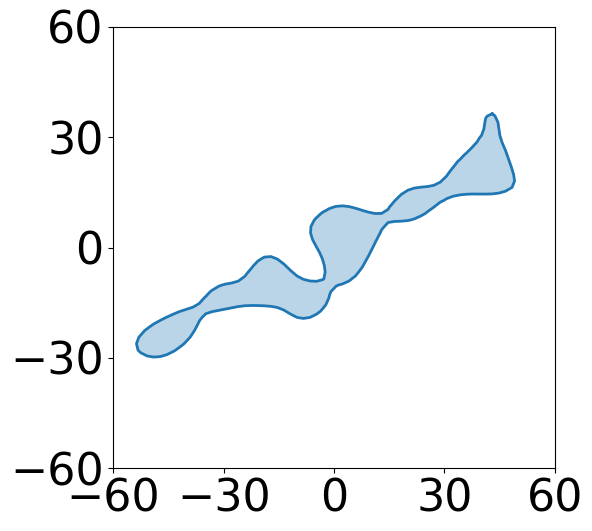

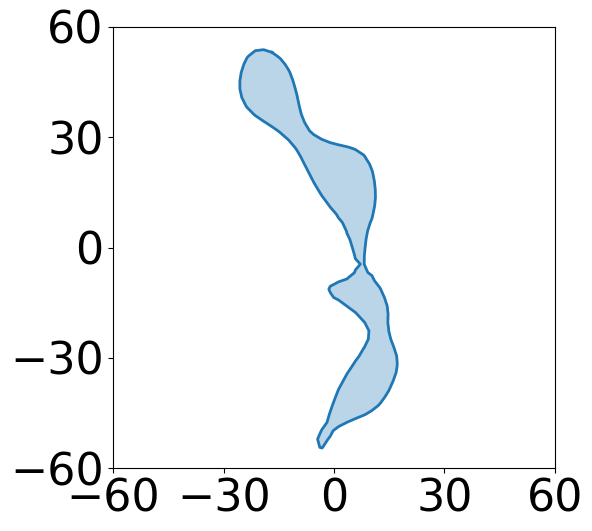

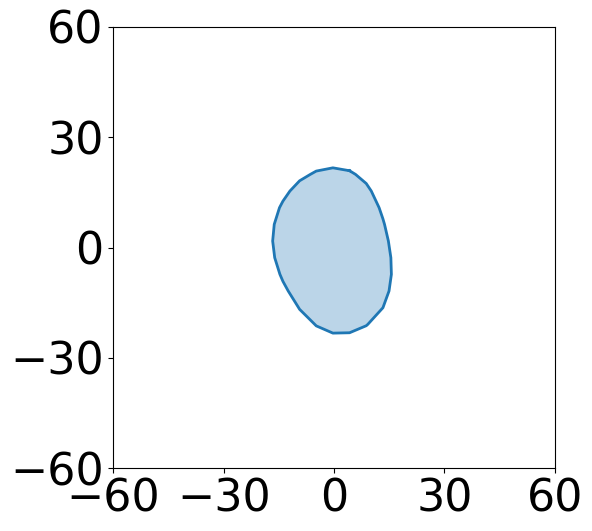

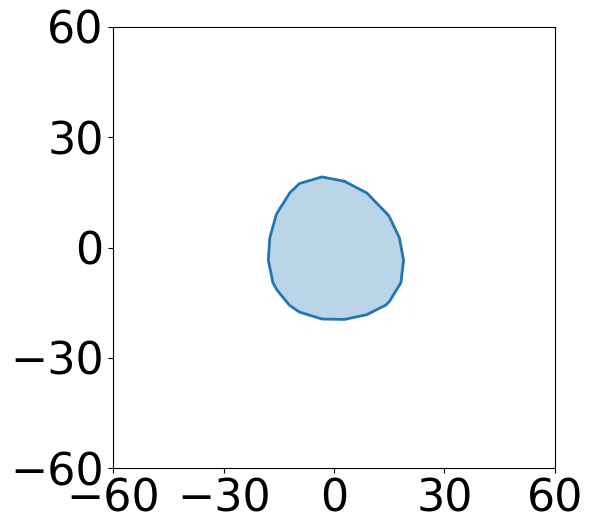

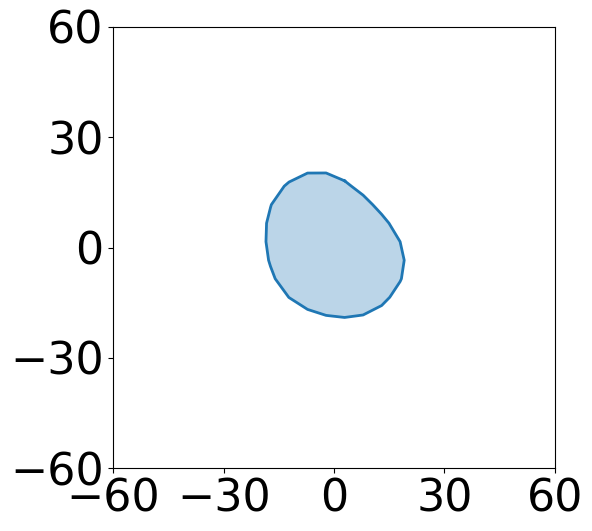

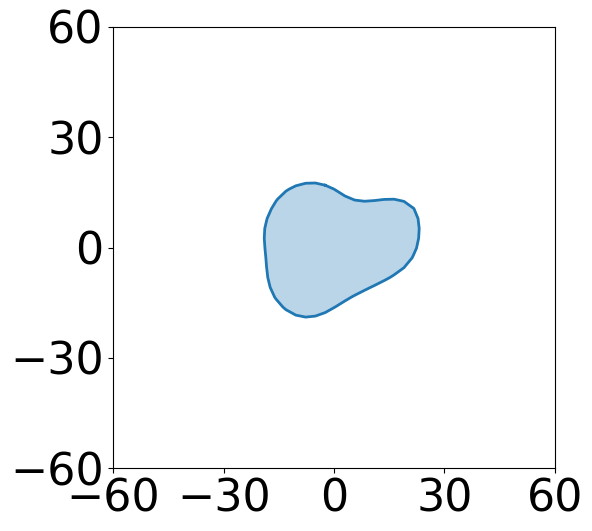

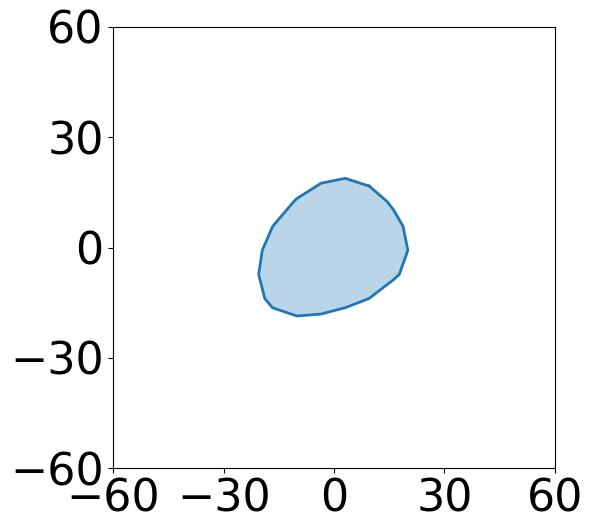

In [36]:

# High Intersection Ratio:
#       circularity  intersection_ratios
# 7782     0.062492               0.2629
# 8978     0.161476               0.2523
# 2534     0.148526               0.2499
# 3337     0.132329               0.2425
# 5033     0.167636               0.2419
# 3480     0.188690               0.2406

#  Low Intersection Ratio:
#       circularity  intersection_ratios
# 5953     0.979371               0.1195
# 927      0.942083               0.1195
# 9910     0.979672               0.1199
# 6920     0.969649               0.1206
# 8344     0.879049               0.1208
# 9922     0.953481               0.1212
inds = [8978,2534,3337,5033,3480]

for i in range(len(inds)):
    cent_x, cent_y = center_shape(all_xs[inds[i]], all_ys[inds[i]],0,0)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.fill(cent_x, cent_y, alpha=0.3)
    ax.plot(cent_x, cent_y, lw=2)
    
    ax.set_xlim(-60, 60)
    ax.set_ylim(-60, 60)
    ax.set_aspect('equal')
    # ax.invert_yaxis()
    ax.set_xticks(np.arange(-60, 61, 30))
    ax.set_yticks(np.arange(-60, 61, 30))
    ax.tick_params(labelsize=32)
    plt.tight_layout()
    plt.savefig(f"Images_for_paper/fig3_highint_sample{i+1}.png")


inds = [927,9910,6920,8344,9922]

for i in range(len(inds)):
    cent_x, cent_y = center_shape(all_xs[inds[i]], all_ys[inds[i]],0,0)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.fill(cent_x, cent_y, alpha=0.3)
    ax.plot(cent_x, cent_y, lw=2)
    
    ax.set_xlim(-60, 60)
    ax.set_ylim(-60, 60)
    ax.set_aspect('equal')
    # ax.invert_yaxis()
    ax.set_xticks(np.arange(-60, 61, 30))
    ax.set_yticks(np.arange(-60, 61, 30))
    ax.tick_params(labelsize=32)
    plt.tight_layout()
    plt.savefig(f"Images_for_paper/fig3_lowint_sample{i+1}.png")

# Fig 3 E,F, Supplementary figure 2

In [3]:
def center_shape(x, y, target_x=200, target_y=200):
    cx, cy = np.mean(x), np.mean(y)
    return x - cx + target_x, y - cy + target_y

def rasterize_shape_mask(x_shape, y_shape, grid_size=0):
    """Rasterize polygon to binary mask (CPU fallback)."""
    x_shifted = np.clip(x_shape.astype(int), 0, grid_size - 1)
    y_shifted = np.clip(y_shape.astype(int), 0, grid_size - 1)
    mask = polygon2mask((grid_size, grid_size), np.column_stack((y_shifted, x_shifted)))
    return mask.astype(np.uint8)


def cpu_check_hits(mask_cpu, x_points, y_points):
    """Check which points fall inside mask on CPU (NumPy version)."""
    x_np = x_points.astype(int)
    y_np = y_points.astype(int)
    
    # Clip to valid mask bounds
    x_np = np.clip(x_np, 0, mask_cpu.shape[1] - 1)
    y_np = np.clip(y_np, 0, mask_cpu.shape[0] - 1)
    
    # Get mask values at those coordinates
    hits = mask_cpu[y_np, x_np]
    
    return int(np.sum(hits)), hits

def sample_uniform_r_ovals2(n_samples,large_radius):
    min_radius = 1
    max_radius = large_radius
    rx_list = []
    ry_list = []
    while len(rx_list) < n_samples:
        batch_size = n_samples - len(rx_list)
        
        r = np.random.uniform(1, 10,batch_size)
    
        ry_min = np.maximum(min_radius, min_radius / r)
        ry_max = np.minimum(max_radius, max_radius / r)
    
        ry = np.random.uniform(ry_min, ry_max,batch_size)
        rx = r * ry
        valid_mask = (rx <= max_radius) & (ry <= max_radius)

        rx_list.extend(rx[valid_mask])
        ry_list.extend(ry[valid_mask])
        return np.array(rx_list[:n_samples]), np.array(ry_list[:n_samples])
def sample_normal_r_ovals(n_samples,large_radius):
    min_radius = 1
    max_radius = large_radius
    rx_list = []
    ry_list = []
    while len(rx_list) < n_samples:
        batch_size = n_samples - len(rx_list)
        ry = np.random.uniform(min_radius, max_radius,batch_size)
        rx = np.random.uniform(min_radius, max_radius,batch_size)
        valid_mask = (rx <= max_radius) & (ry <= max_radius)

        rx_list.extend(rx[valid_mask])
        ry_list.extend(ry[valid_mask])

    return np.array(rx_list[:n_samples]), np.array(ry_list[:n_samples])
    
def random_point_in_circle(radius):
    # Random direction (unit vector)
    direction = np.random.normal(size=2)
    direction /= np.linalg.norm(direction)
    # Random radius, scaled to preserve uniform volume density
    r = np.random.random() ** (1/2) * radius
    return direction * r
def minmax_distance(x, y):

    # Stack points for easier computation
    points = np.column_stack((x, y))
    
    # Compute centroid
    center = points.mean(axis=0)
    
    # Compute distances from centroid to all points
    distances = np.linalg.norm(points - center, axis=1)
    
    # Find minimum distance
    min_dist = np.min(distances)
    max_dist = np.max(distances)
    
    return min_dist, max_dist


def simulate_2D_movingcent(args):
    (large_radius, x_shape, y_shape, n_samples) = args

    # --- Define grid ---
    grid_size = int(large_radius * 2)
    grid_center_x = grid_size // 2
    grid_center_y = grid_size // 2

    mindist,maxdist = minmax_distance(x_shape, y_shape)
    intersections = 0
    
    rx, ry = sample_uniform_r_ovals2(n_samples, large_radius)
    nrx, nry = sample_normal_r_ovals(n_samples, large_radius)
    hit_circle = 0
    intersect_circle = 0
    tot_hit_circle = 0
    
    hit_unioval = 0
    tot_hit_unioval = 0
    intersect_unioval = 0
    
    hit_normoval = 0
    intersect_normoval = 0
    tot_hit_normoval = 0
    
    hit_cloud = 0
    tot_hit_cloud = 0
    for i in range(n_samples):
        while True:
            if maxdist >=large_radius:
                center1 = 0
                center2 = 0
                x_shifted = x_shape + (center1 - np.mean(x_shape)) + grid_center_x
                y_shifted = y_shape + (center2 - np.mean(y_shape)) + grid_center_y
                break
            center1,center2 = random_point_in_circle(large_radius-mindist)
            x_shifted = x_shape + (center1 - np.mean(x_shape)) + grid_center_x
            y_shifted = y_shape + (center2 - np.mean(y_shape)) + grid_center_y
            if np.all(np.linalg.norm(np.column_stack((x_shifted-grid_center_x, y_shifted-grid_center_y)), axis=1) <= large_radius):
                break
        mask = polygon2mask((grid_size, grid_size), np.column_stack((y_shifted, x_shifted)))
        circle_radius = np.random.uniform(0,large_radius)
        max_center_dist = large_radius - circle_radius
        dist_i = np.random.uniform(0, max_center_dist)
        ccx , ccy = random_point_in_circle(dist_i) + [grid_center_x,grid_center_y]
        n_circ_pts = int(2*np.pi*circle_radius)
        ang = np.linspace(0, 2 * np.pi,n_circ_pts, endpoint=False)
        x_circ_pts = ccx + circle_radius * np.cos(ang)
        y_circ_pts = ccy + circle_radius * np.sin(ang)
        
        hit_circle_iter, flags_c_iter = cpu_check_hits(mask, x_circ_pts, y_circ_pts)
        hit_circle = hit_circle + hit_circle_iter
        intersect_circle = intersect_circle + int(np.any(flags_c_iter))
        tot_hit_circle = tot_hit_circle + n_circ_pts
        
        rx_i = rx[i]
        ry_i = ry[i]
        min_r = min(rx_i, ry_i)
        max_center_dist = large_radius - min_r
        
        perimeter_est = np.pi * (3*(rx_i+ry_i) - np.sqrt((3*rx_i + ry_i)*(rx_i + 3*ry_i)))
        oval_n_pts = int(np.ceil(perimeter_est))
        while True:
            dist_i = np.random.uniform(0, max_center_dist) 
            cx, cy = random_point_in_circle(dist_i) + [grid_center_x,grid_center_y]
            phi_i = np.random.uniform(0, 2*np.pi)
            cos_phi = np.cos(phi_i)
            sin_phi = np.sin(phi_i)
    
            theta = np.linspace(0, 2*np.pi, oval_n_pts*10, endpoint=False)
            x = rx_i * np.cos(theta)
            y = ry_i * np.sin(theta)
    
            pts = np.stack([x, y], axis=1)
            d = np.linalg.norm(np.diff(pts, axis=0, append=pts[:1]), axis=1)
            cum = np.concatenate([[0.], np.cumsum(d)])
            total_length = cum[-1]
    
            target_dist = np.linspace(0, total_length, oval_n_pts, endpoint=False)
            theta_equal = np.interp(target_dist, cum[:-1], theta)
            x_eq = rx_i * np.cos(theta_equal)
            y_eq = ry_i * np.sin(theta_equal)
            x_pts = x_eq * cos_phi - y_eq * sin_phi + cx
            y_pts = x_eq * sin_phi + y_eq * cos_phi + cy
    
            # Check if all points lie within the large circle
            dist_from_center_sq = (x_pts - grid_center_x)**2 + (y_pts - grid_center_y)**2
            if np.all(dist_from_center_sq <= large_radius**2):
                break
        
        hit_unioval_iter, flags_unioval_iter = cpu_check_hits(mask, x_pts, y_pts)
        hit_unioval = hit_unioval + hit_unioval_iter
        intersect_unioval = intersect_unioval + int(np.any(flags_unioval_iter))
        tot_hit_unioval = tot_hit_unioval + oval_n_pts

        
        
        nrx_i = nrx[i]
        nry_i = nry[i]
        min_r = min(nrx_i, nry_i)
        max_center_dist = large_radius - min_r
        perimeter_est = np.pi * (3*(nrx_i+nry_i) - np.sqrt((3*nrx_i + nry_i)*(nrx_i + 3*nry_i)))
        noval_n_pts = int(np.ceil(perimeter_est))
        while True:
            dist_i = np.random.uniform(0, max_center_dist) 
            ncx, ncy = random_point_in_circle(dist_i) + [grid_center_x,grid_center_y]
            phi_i = np.random.uniform(0, 2*np.pi)
            cos_phi = np.cos(phi_i)
            sin_phi = np.sin(phi_i)
    
            theta = np.linspace(0, 2*np.pi, noval_n_pts*10, endpoint=False)
            x = nrx_i * np.cos(theta)
            y = nry_i * np.sin(theta)
    
            pts = np.stack([x, y], axis=1)
            d = np.linalg.norm(np.diff(pts, axis=0, append=pts[:1]), axis=1)
            cum = np.concatenate([[0.], np.cumsum(d)])
            total_length = cum[-1]
    
            target_dist = np.linspace(0, total_length, noval_n_pts, endpoint=False)
            theta_equal = np.interp(target_dist, cum[:-1], theta)
            x_eq = nrx_i * np.cos(theta_equal)
            y_eq = nry_i * np.sin(theta_equal)
            nx_pts = x_eq * cos_phi - y_eq * sin_phi + ncx
            ny_pts = x_eq * sin_phi + y_eq * cos_phi + ncy
    
    
            # Check if all points lie within the large circle
            ndist_from_center_sq = (nx_pts - grid_center_x)**2 + (ny_pts - grid_center_y)**2
            if np.all(ndist_from_center_sq <= large_radius**2):
                break
        hit_normoval_iter, flags_normoval_iter = cpu_check_hits(mask, nx_pts, ny_pts)
        hit_normoval = hit_normoval + hit_normoval_iter
        intersect_normoval = intersect_normoval + int(np.any(flags_normoval_iter))
        tot_hit_normoval = tot_hit_normoval + noval_n_pts


        points_target = (n_circ_pts + oval_n_pts + noval_n_pts) // 3
        xrands = []
        yrands = []
        for i in range(points_target):
            xrand, yrand = random_point_in_circle(large_radius)+[grid_center_x,grid_center_y]
            xrands.append(xrand)
            yrands.append(yrand)
        xrands = np.array(xrands)
        yrands = np.array(yrands)
        hit_cloud_iter, _ = cpu_check_hits(mask, xrands, yrands)
        hit_cloud = hit_cloud + hit_cloud_iter
        tot_hit_cloud = tot_hit_cloud + points_target
        
    return {
        "radius": large_radius,
        "circle_intersect_ratio": intersect_circle / n_samples,
        "uni_oval_intersect_ratio": intersect_unioval / n_samples,
        "norm_oval_intersect_ratio": intersect_normoval/n_samples,
        "circle_hit_ratio": hit_circle / tot_hit_circle,
        "uni_oval_hit_ratio": hit_unioval / tot_hit_unioval,
        "norm_oval_hit_ratio": hit_normoval/tot_hit_normoval,
        "cloud_hit_ratio": hit_cloud / tot_hit_cloud
    }

In [ ]:
with open("shapes_data.pkl", "rb") as f:
    data = pickle.load(f)

#circularities = data['circularities']
#intersection_ratios = data['intersection_ratios']
all_xs = data['x_coords']
all_ys = data['y_coords']
center = (0, 0)
n_samples = 5000
radii = np.append(np.arange(17.5, 400, 20), 400)
nshapes = 100
n_workers = 8  # number of parallel processes

all_results = []

def process_shape(idx):
    """Process a single shape and return its results for all radii."""
    x = all_xs[idx]
    y = all_ys[idx]

    shape_results = []
    for r in radii:
        args = (r, x, y, n_samples)
        res = simulate_2D_movingcent(args)
        shape_results.append(res)
    return idx, shape_results

# Run in parallel
with ProcessPoolExecutor(max_workers=n_workers) as executor:
    futures = [executor.submit(process_shape, idx) for idx in range(nshapes)]

    for f in tqdm(as_completed(futures), total=nshapes, desc="Processing shapes (parallel)"):
        idx, results = f.result()
        all_results.append(results)

with open("all_res_2Dmovingcent.pkl", "wb") as f:
   pickle.dump(all_results, f) #save the new results


    

In [ ]:

with open("all_res_2Dmovingcent.pkl", "rb") as f:
    all_results = pickle.load(f) #load it as all results again

radii = np.append(np.arange(17.5, 400, 20), 400)

nrx_i = 1
nry_i = 0.3
perimeter_est = 30
noval_n_pts = int(np.ceil(perimeter_est))
phi_i = np.pi
cos_phi = np.cos(phi_i)
sin_phi = np.sin(phi_i)

theta = np.linspace(0, 2*np.pi, noval_n_pts*10, endpoint=False)
x = nrx_i * np.cos(theta)
y = nry_i * np.sin(theta)

pts = np.stack([x, y], axis=1)
d = np.linalg.norm(np.diff(pts, axis=0, append=pts[:1]), axis=1)
cum = np.concatenate([[0.], np.cumsum(d)])
total_length = cum[-1]

target_dist = np.linspace(0, total_length, noval_n_pts, endpoint=False)
theta_equal = np.interp(target_dist, cum[:-1], theta)
x_eq = nrx_i * np.cos(theta_equal)
y_eq = nry_i * np.sin(theta_equal)
nx_pts = x_eq * cos_phi - y_eq * sin_phi 
ny_pts = x_eq * sin_phi + y_eq * cos_phi 




rx_i = 1
ry_i = 0.7
perimeter_est = 30
oval_pts = int(np.ceil(perimeter_est))
phi_i = np.pi
cos_phi = np.cos(phi_i)
sin_phi = np.sin(phi_i)

theta = np.linspace(0, 2*np.pi, oval_pts*100, endpoint=False)
x = rx_i * np.cos(theta)
y = ry_i * np.sin(theta)

pts = np.stack([x, y], axis=1)
d = np.linalg.norm(np.diff(pts, axis=0, append=pts[:1]), axis=1)
cum = np.concatenate([[0.], np.cumsum(d)])
total_length = cum[-1]

target_dist = np.linspace(0, total_length, oval_pts, endpoint=False)
theta_equal = np.interp(target_dist, cum[:-1], theta)
x_eq = rx_i * np.cos(theta_equal)
y_eq = ry_i * np.sin(theta_equal)
x_pts = x_eq * cos_phi - y_eq * sin_phi 
y_pts = x_eq * sin_phi + y_eq * cos_phi 

circle_intersect_ratio


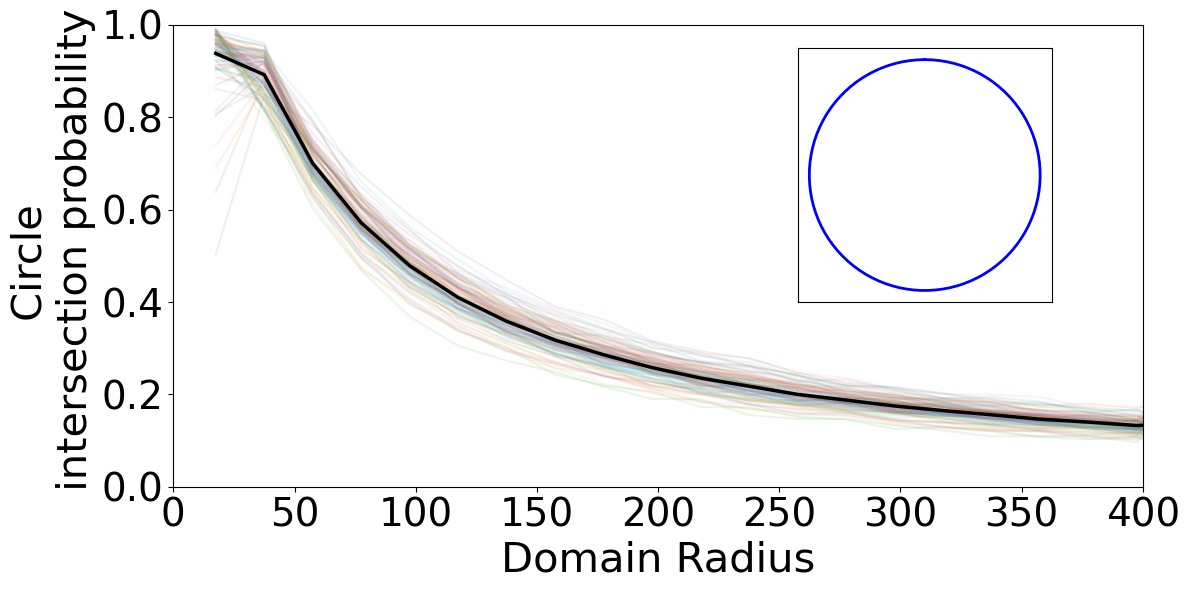

uni_oval_intersect_ratio


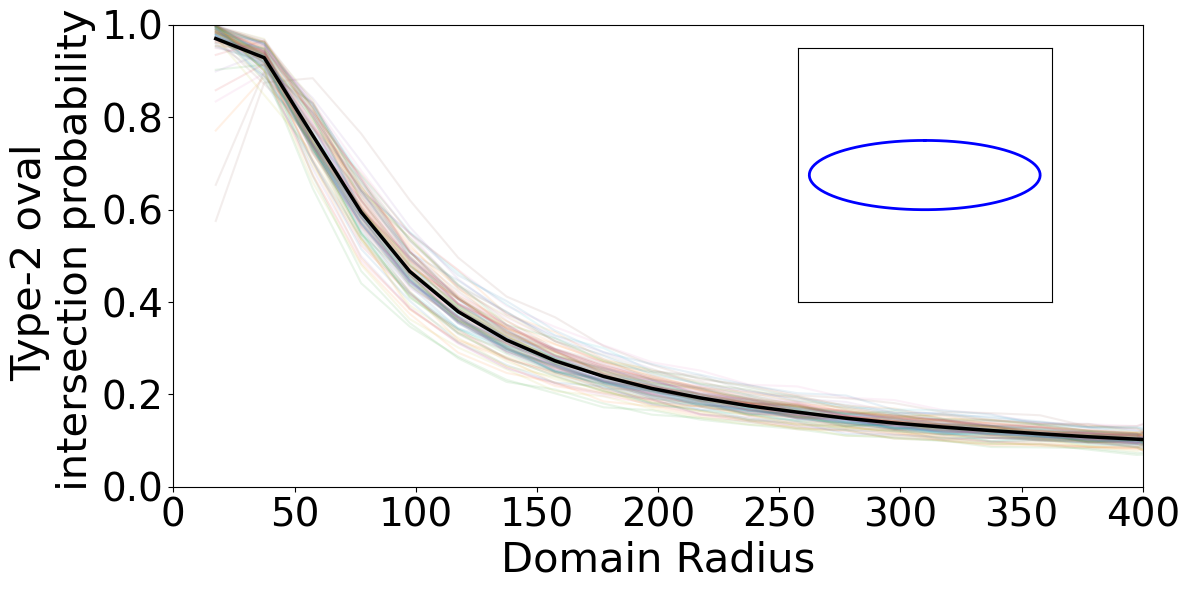

norm_oval_intersect_ratio


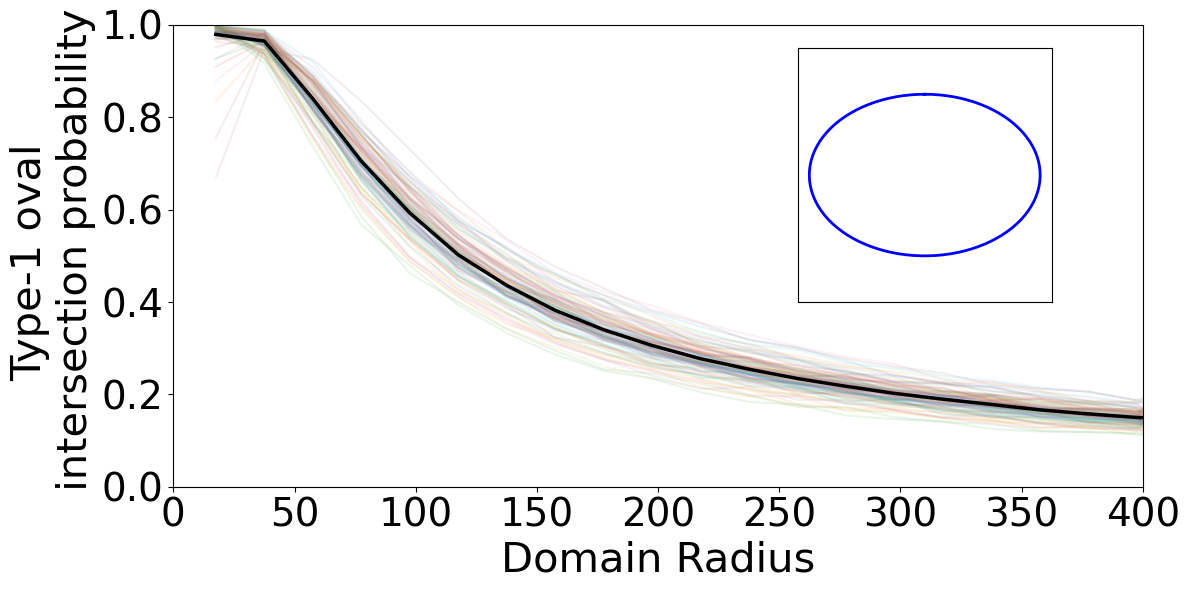

circle_hit_ratio


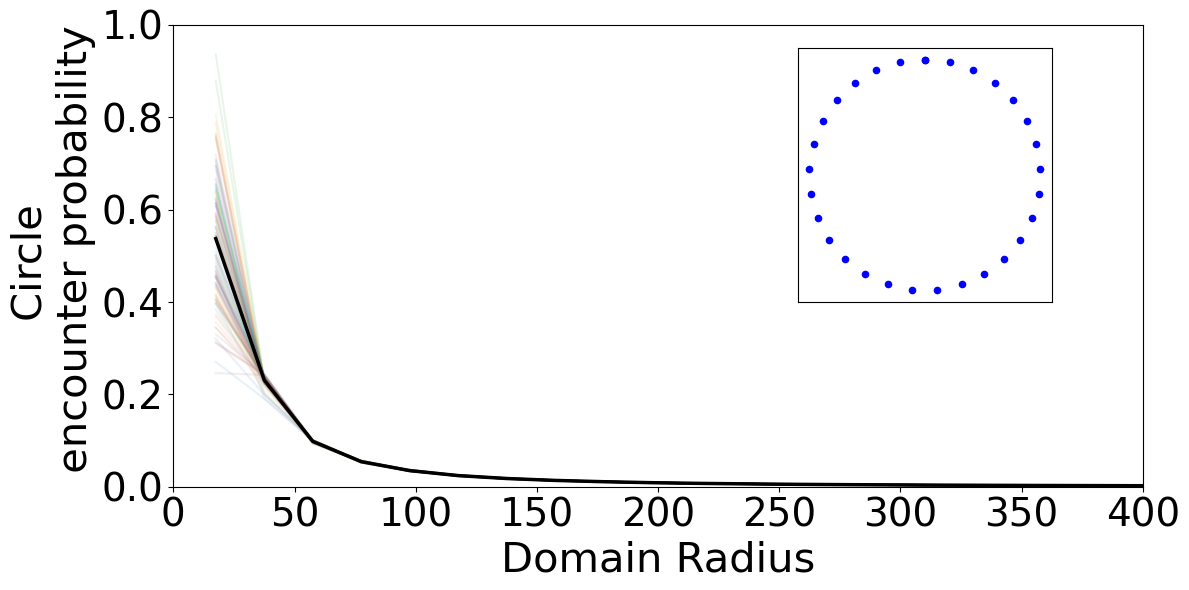

uni_oval_hit_ratio


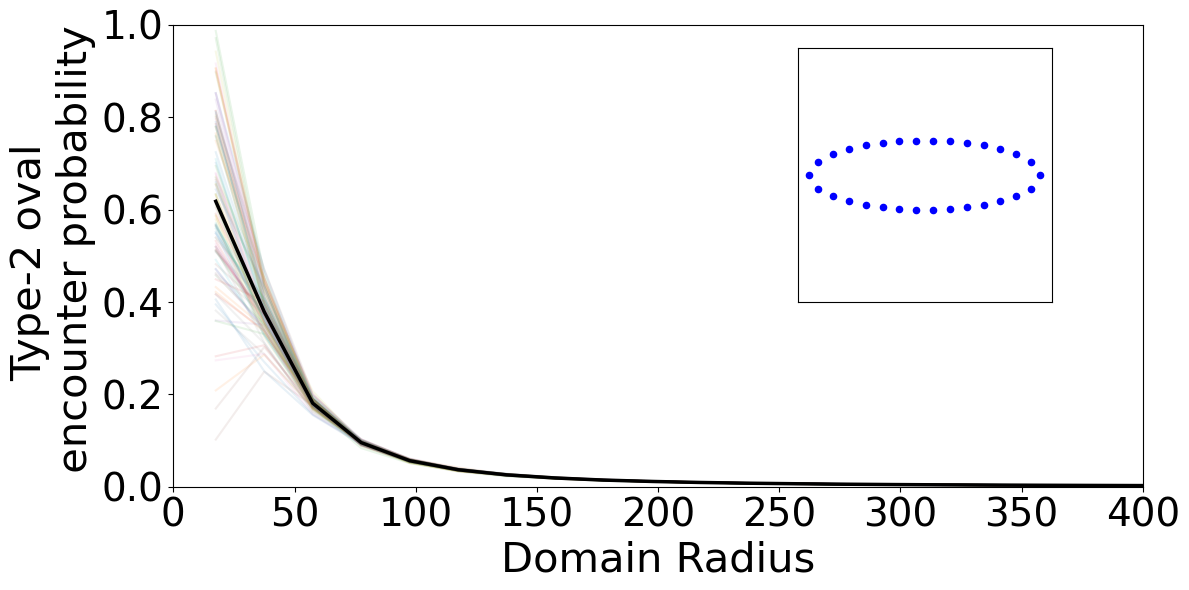

norm_oval_hit_ratio


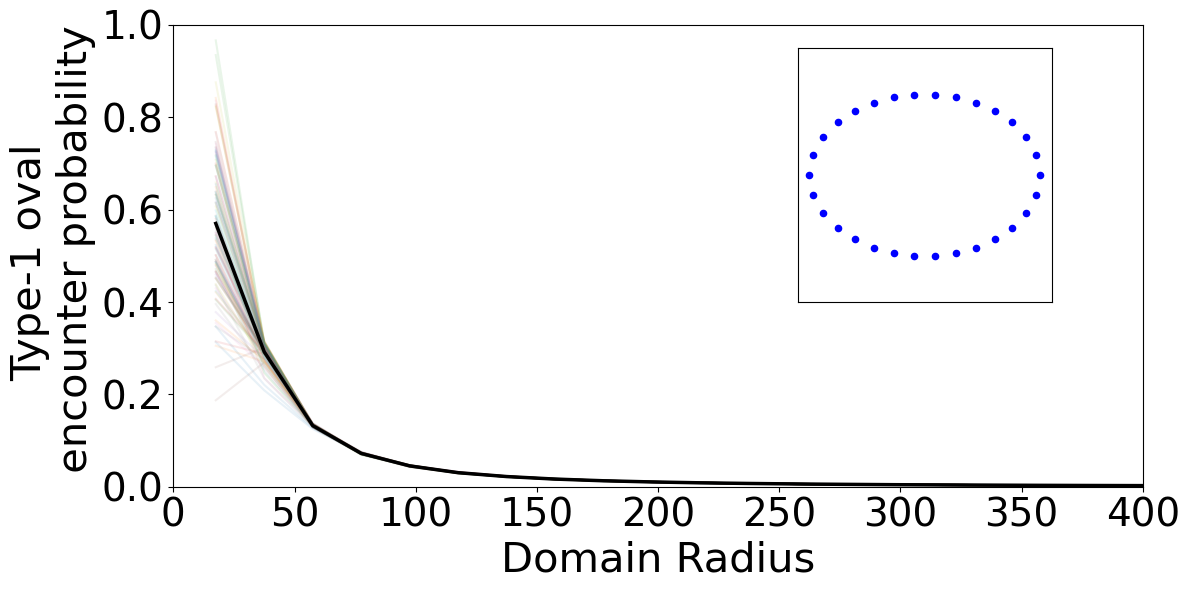

cloud_hit_ratio


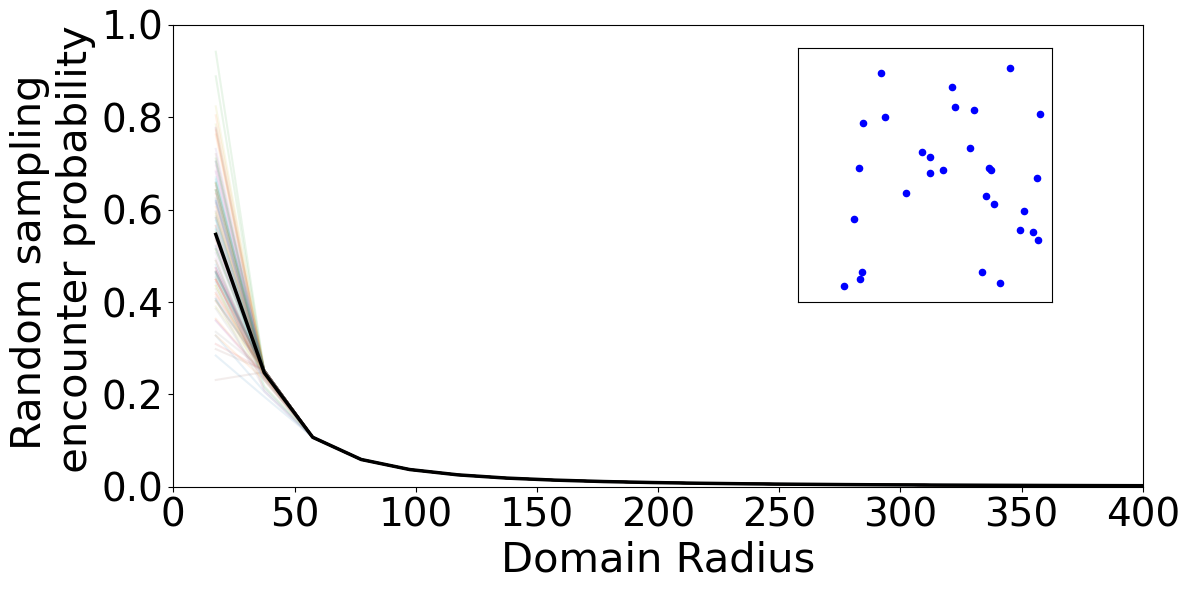

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
sines = np.sin(np.linspace(0,np.pi*2,100))
cosines = np.cos(np.linspace(0,np.pi*2,100))
sines2 = np.sin(np.linspace(0,np.pi*2,30))
cosines2 = np.cos(np.linspace(0,np.pi*2,30))
inset_dict = {"circle_intersect_ratio":[sines, cosines],
              "uni_oval_intersect_ratio":[sines, cosines*0.3],
              "norm_oval_intersect_ratio":[sines, cosines*0.7],
              "circle_hit_ratio":[sines2, cosines2],
              "uni_oval_hit_ratio":[nx_pts,ny_pts],
              "norm_oval_hit_ratio":[x_pts, y_pts],
              "cloud_hit_ratio":[np.random.uniform(-1,1,30), np.random.uniform(-1,1,30)]}

metrics = [
    ("circle_intersect_ratio", "Circle \n intersection probability"),
    ("uni_oval_intersect_ratio", "Type-2 oval \n intersection probability"),
    ("norm_oval_intersect_ratio", "Type-1 oval \n intersection probability"),
    ("circle_hit_ratio", "Circle \n encounter probability"),
    ("uni_oval_hit_ratio", "Type-2 oval \n encounter probability"),
    ("norm_oval_hit_ratio", "Type-1 oval \n encounter probability"),
    ("cloud_hit_ratio", "Random sampling \n encounter probability"),
]
counter = 0
for metric_key, metric_label in metrics:
    plt.figure(figsize=(12, 6))
    ax = plt.gca()

    # Collect all metric values into a matrix for averaging
    metric_matrix = np.array([[r[metric_key] for r in shape_result] for shape_result in all_results])
    print(metric_key)
    # Plot each shape’s line (semi-transparent)
    for i, values in enumerate(metric_matrix):
        ax.plot(radii, values, label=f"Shape {i}", alpha=0.1)

    # Plot the average line (bold)
    avg_values = np.mean(metric_matrix, axis=0)
    ax.plot(radii, avg_values, color='black', linewidth=2.5, label='Average')

    # Formatting
    ax.set_xlabel("Domain Radius", fontsize=30)
    ax.set_ylabel(metric_label, fontsize=30)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, np.max(radii))
    ax.tick_params(labelsize=28)
    plt.tight_layout()

    # --- Add inset ---
    axins = ax.inset_axes([0.50, 0.4, 0.55, 0.55]) # position inside main plot
    x_inset, y_inset = inset_dict[metric_key]
    axins.autoscale(False)

    if counter <=2:
        axins.plot(x_inset, y_inset, color='blue', linewidth = 2)
    else:
        axins.scatter(x_inset, y_inset, color='blue',s=20)
    axins.set_aspect('equal')
    axins.set_xlim(-1.1, 1.1)
    axins.set_ylim(-1.1, 1.1)
    axins.set_xticks([])
    axins.set_yticks([])

    # Optional: connect inset to main plot with lines
    

    # Save and show
    plt.savefig(f"fig3_{metric_key}.png", bbox_inches='tight')
    counter = counter+1
    plt.show()

circle_intersect_ratio
uni_oval_intersect_ratio
norm_oval_intersect_ratio


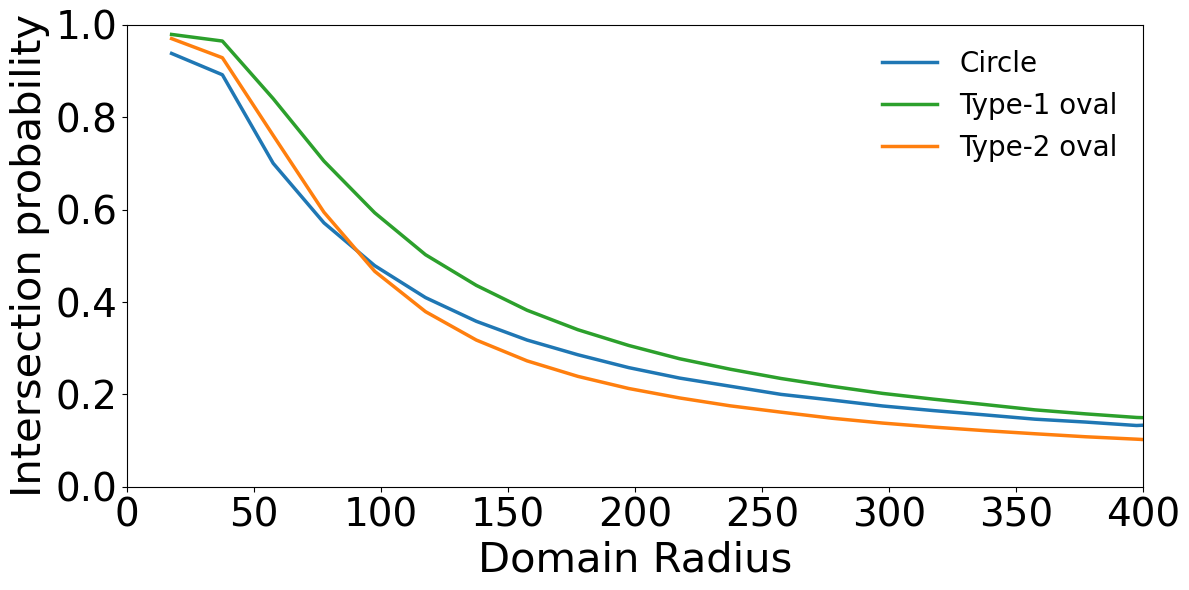

In [15]:

plt.figure(figsize=(12, 6))
met = ["Circle","Type-2 oval", "Type-1 oval"]
i=0
for metric_key, metric_label in metrics[:3]:
    print(metric_key)
    # Extract all values for this metric across shapes
    metric_matrix = np.array([[r[metric_key] for r in shape_result] for shape_result in all_results])
    avg_values = np.mean(metric_matrix, axis=0)
    
    # Plot the average line
    plt.plot(radii, avg_values, label=met[i], linewidth=2.5)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    i = i+1
plt.xlabel("Domain Radius",fontsize = 30)
plt.ylabel("Intersection probability",fontsize = 30)

plt.ylim(0, 1)
plt.xlim(0, np.max(radii))
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 2, 1]  # Circular, Oval, Uniform oval
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           loc='best', fontsize=20,frameon=False)
plt.tight_layout()
plt.savefig("Images_for_paper/fig3_allLCs.png")


plt.show()

/var/tmp/pbs.1220840.pbs-7/ipykernel_868429/140995046.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


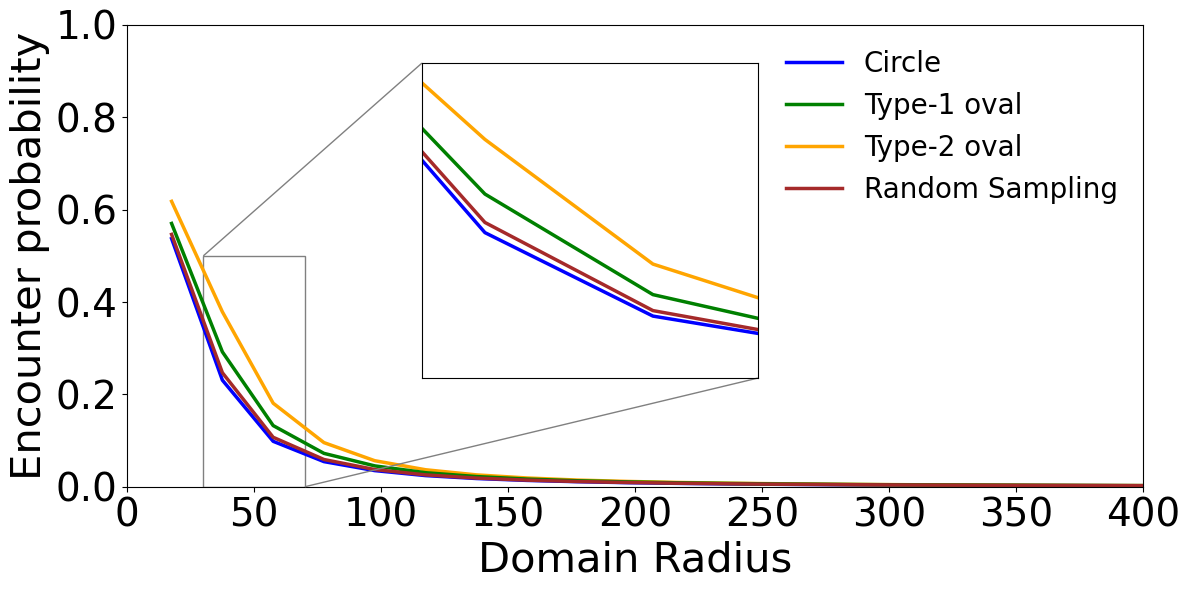

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.figure(figsize=(12, 6))
col = ['blue','orange','green',"brown"]
met = ["Circle","Type-2 oval", "Type-1 oval", "Random Sampling"]
i=0

for metric_key, metric_label in metrics[3:]:
    # Extract all values for this metric across shapes
    metric_matrix = np.array([[r[metric_key] for r in shape_result] for shape_result in all_results])
    avg_values = np.mean(metric_matrix, axis=0)
    
    # Plot the average line
    plt.plot(radii, avg_values, label=met[i], linewidth=2.5, color=col[i])
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    i += 1

plt.xlabel("Domain Radius", fontsize=30)
plt.ylabel("Encounter probability", fontsize=30)
plt.ylim(0, 1)
plt.xlim(0, np.max(radii))

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 2, 1, 3]  # Circular, Oval, Uniform oval, Random
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           loc='best', fontsize=20, frameon=False)

# Add inset
ax = plt.gca()
# inset axes [x0, y0, width, height] in fraction of parent axes
axins = inset_axes(ax, width="35%", height="35%",bbox_to_anchor=(0.35, 0.35, 0.8, 1.5),
                   bbox_transform=plt.gcf().transFigure, loc='lower left')  

# Plot the same data in inset
i = 0
for metric_key, metric_label in metrics[3:]:
    metric_matrix = np.array([[r[metric_key] for r in shape_result] for shape_result in all_results])
    avg_values = np.mean(metric_matrix, axis=0)
    axins.plot(radii, avg_values, color=col[i], linewidth=2.5)
    i += 1

# Set limits for zoom region in inset (adjust as needed)
x1, x2 = 30, 70  # x-axis zoom range
y1, y2 = 0.0, 0.5              # y-axis zoom range
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Remove ticks for inset
axins.tick_params(axis='both', labelsize=16)
axins.set_xticks([])
axins.set_yticks([])

# Draw rectangle showing zoom area on main plot
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.tight_layout()

plt.savefig("Images_for_paper/fig3_allpoints.png")
plt.show()


# Figure 3 A,B,C,D

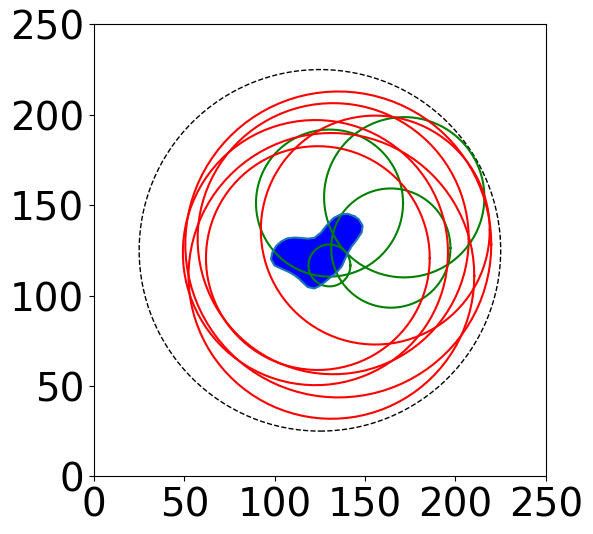

In [9]:
large_radius = 100
n_samples = 10
grid_size = int(large_radius * 2)
grid_center = large_radius+25

# Sample circles
theta = np.random.uniform(0, 2 * np.pi, n_samples)
circle_radii = np.random.uniform(1, large_radius, n_samples)
max_center_dist = large_radius - circle_radii
radii_center_dists = np.random.uniform(0, max_center_dist)

circle_centers_x = grid_center + radii_center_dists * np.cos(theta)
circle_centers_y = grid_center + radii_center_dists * np.sin(theta)
xvar, yvar = center_shape(all_xs[0],all_ys[0],target_x = 125, target_y = 125)
shape_path = Path(np.column_stack((xvar, yvar))) 
# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')
circle = plt.Circle((grid_center, grid_center), large_radius, fill=False, linestyle='--', label='Large Circle')
ax.add_artist(circle)

for cx, cy, r in zip(circle_centers_x, circle_centers_y, circle_radii):
    angles = np.linspace(0, 2 * np.pi, 100)
    x = cx + r * np.cos(angles)
    y = cy + r * np.sin(angles)
    points = np.column_stack((x, y))

    intersects = np.any(shape_path.contains_points(points))
    color = 'green' if intersects else 'red'

    ax.plot(x, y, color=color)

ax.set_xlim(0, grid_size+50)
ax.set_ylim(0, grid_size+50)
ax.tick_params( labelsize=28)
plt.plot(xvar,yvar)
plt.xticks(ticks = [0,50,100,150,200,250],label = [0,50,100,150,200,250])
plt.yticks(ticks = [0,50,100,150,200,250],label = [0,50,100,150,200,250])
plt.fill(xvar,yvar, 'blue')
plt.tight_layout()
plt.gcf().savefig("fig3_circ_lc_examples.png")
plt.show()


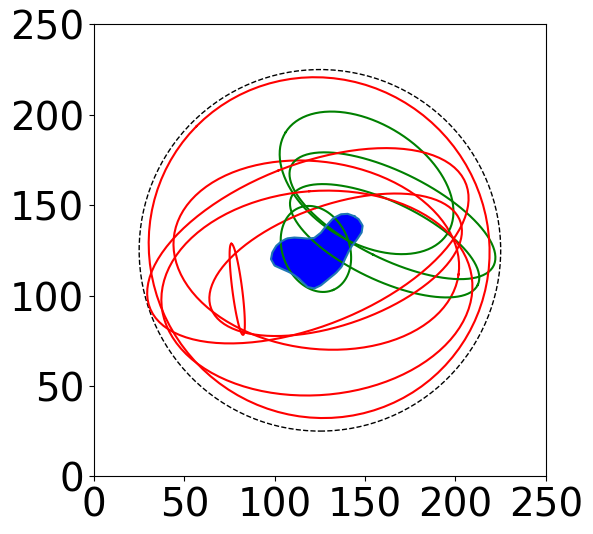

In [10]:
from matplotlib.lines import Line2D 
import matplotlib.pyplot as plt 
large_radius = 100
n_samples = 10
grid_size = int(large_radius * 2)
grid_center = large_radius+25
rx, ry = sample_normal_r_ovals(n_samples, large_radius)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')
circle = plt.Circle((grid_center, grid_center), large_radius, fill=False, linestyle='--', label='Large Circle')
ax.add_artist(circle)

xvar, yvar = center_shape(all_xs[0],all_ys[0],target_x = 125, target_y = 125)
shape_path = Path(np.column_stack((xvar, yvar))) 
for i in range(n_samples):
    accepted = False
    rxi, ryi = rx[i], ry[i]
    while accepted ==False:
        phi = np.random.uniform(0, 2 * np.pi)
        theta = np.random.uniform(0, 2 * np.pi)
        dist = np.random.uniform(0, large_radius - min(rxi, ryi))
        cx = grid_center + dist * np.cos(theta)
        cy = grid_center + dist * np.sin(theta)
    
        angles = np.linspace(0, 2 * np.pi, 100)
        x = cx + rxi * np.cos(angles) * np.cos(phi) - ryi * np.sin(angles) * np.sin(phi)
        y = cy + rxi * np.cos(angles) * np.sin(phi) + ryi * np.sin(angles) * np.cos(phi)
        sdist_from_center_sq = (x - grid_center)**2 + (y - grid_center)**2
        if np.all(sdist_from_center_sq <= large_radius**2):
            accepted = True
            points = np.column_stack((x, y))
            intersects = np.any(shape_path.contains_points(points))
            color = 'green' if intersects else 'red'
            ax.plot(x, y, color=color)
ax.set_xlim(0, grid_size+50)
ax.set_ylim(0, grid_size+50)
ax.tick_params( labelsize=28)

plt.xticks(ticks = [0,50,100,150,200,250],label = [0,50,100,150,200,250])
plt.yticks(ticks = [0,50,100,150,200,250],label = [0,50,100,150,200,250])
plt.plot(xvar,yvar)
plt.fill(xvar,yvar, 'blue')
plt.tight_layout()
plt.gcf().savefig("fig3_oval_lc_examples.png")
plt.show()

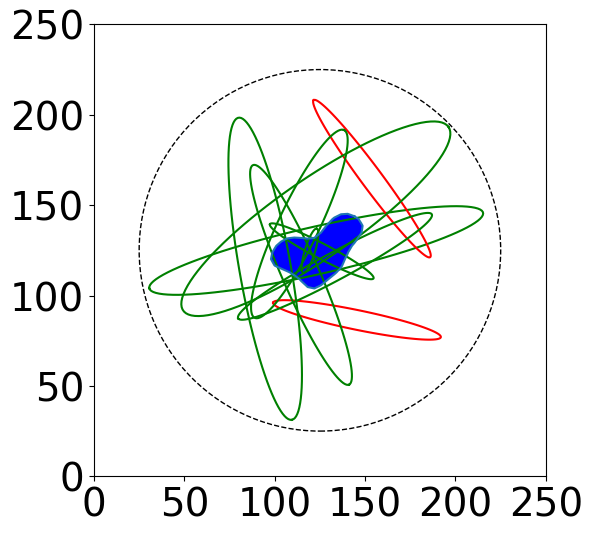

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 

large_radius = 100
n_samples = 10
grid_size = int(large_radius * 2)
grid_center = large_radius+25
rx, ry = sample_uniform_r_ovals2(n_samples, large_radius)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')
circle = plt.Circle((grid_center, grid_center), large_radius, fill=False, linestyle='--', label='Large Circle')
ax.add_artist(circle)

xvar, yvar = center_shape(all_xs[0],all_ys[0],target_x = 125, target_y = 125)
shape_path = Path(np.column_stack((xvar, yvar))) 
for i in range(n_samples):
    accepted = False
    rxi, ryi = rx[i], ry[i]
    while accepted ==False:
        phi = np.random.uniform(0, 2 * np.pi)
        theta = np.random.uniform(0, 2 * np.pi)
        dist = np.random.uniform(0, large_radius - min(rxi, ryi))
        cx = grid_center + dist * np.cos(theta)
        cy = grid_center + dist * np.sin(theta)
    
        angles = np.linspace(0, 2 * np.pi, 100)
        x = cx + rxi * np.cos(angles) * np.cos(phi) - ryi * np.sin(angles) * np.sin(phi)
        y = cy + rxi * np.cos(angles) * np.sin(phi) + ryi * np.sin(angles) * np.cos(phi)
        sdist_from_center_sq = (x - grid_center)**2 + (y - grid_center)**2
        if np.all(sdist_from_center_sq <= large_radius**2):
            accepted = True
            points = np.column_stack((x, y))
            intersects = np.any(shape_path.contains_points(points))
            color = 'green' if intersects else 'red'
            ax.plot(x, y, color=color)

ax.tick_params( labelsize=28)

plt.xticks(ticks = [0,50,100,150,200,250],label = [0,50,100,150,200,250])
plt.yticks(ticks = [0,50,100,150,200,250],label = [0,50,100,150,200,250])
ax.set_xlim(0, grid_size+50)
ax.set_ylim(0, grid_size+50)
ax.tick_params(labelsize=28)
plt.plot(xvar,yvar)
plt.fill(xvar,yvar, 'blue')
plt.tight_layout()

plt.gcf().savefig("fig3_strong_oval_lc_examples.png")

plt.show()


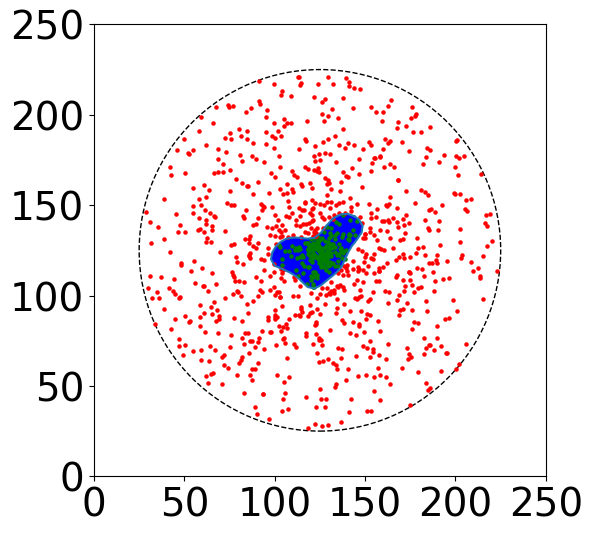

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Setup
large_radius = 100
total_points_target = 1000
grid_center = large_radius+25
grid_size = int(large_radius * 2)

r = np.random.uniform(0, large_radius, total_points_target)
theta = 2 * np.pi * np.random.rand(total_points_target)

x_rand = grid_center + r * np.cos(theta)
y_rand = grid_center + r * np.sin(theta)

# Plot

points = np.column_stack((x_rand, y_rand))
points = np.column_stack((x_rand, y_rand))
inside = shape_path.contains_points(points)

# Separate points
x_inside = x_rand[inside]
y_inside = y_rand[inside]
x_outside = x_rand[~inside]
y_outside = y_rand[~inside]
fig, ax = plt.subplots(figsize=(6, 6))
# Plot each group separately
plt.plot(xvar,yvar)
plt.fill(xvar,yvar, 'blue')
circle = plt.Circle((grid_center, grid_center), large_radius, fill=False, linestyle='--', label='Large Circle')
ax.add_artist(circle)
ax.scatter(x_inside, y_inside, s=5, color='green', label='Hits')
ax.scatter(x_outside, y_outside, s=5, color='red', label='Misses')

ax.set_aspect('equal')

xvar, yvar = center_shape(all_xs[0],all_ys[0],target_x = 125, target_y = 125)


ax.set_xlim(0, grid_size+50)
ax.set_ylim(0, grid_size+50)

ax.tick_params( labelsize=28)

plt.xticks(ticks = [0,50,100,150,200,250],label = [0,50,100,150,200,250])
plt.yticks(ticks = [0,50,100,150,200,250],label = [0,50,100,150,200,250])
plt.tight_layout()
plt.gcf().savefig("fig3_cloud_examples.png")
plt.show()


# Supplementary Figure 8

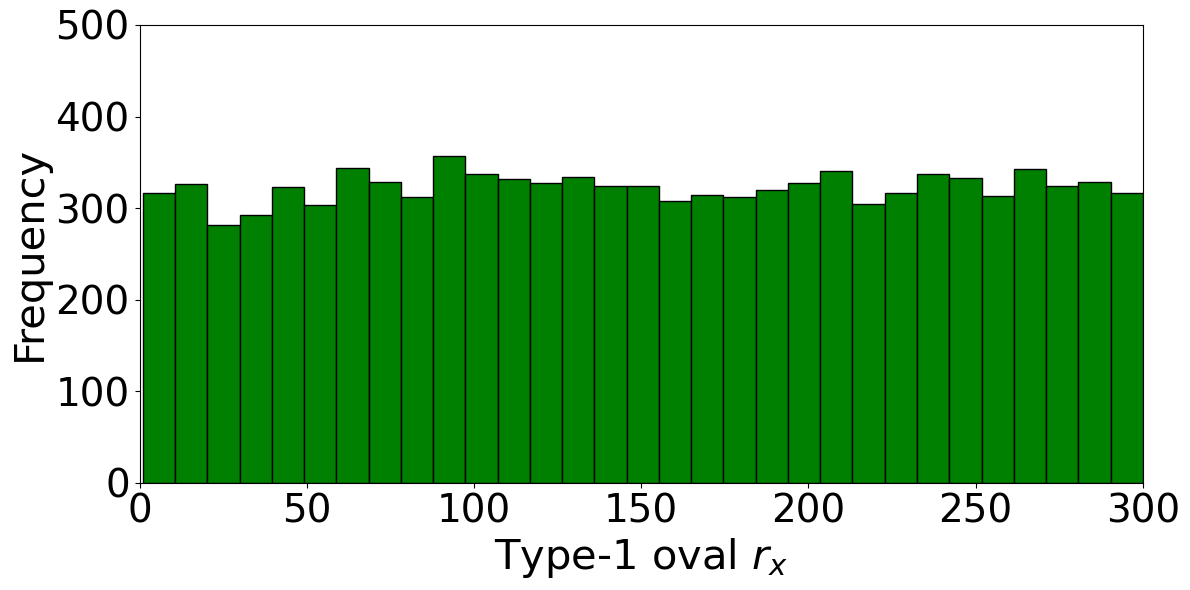

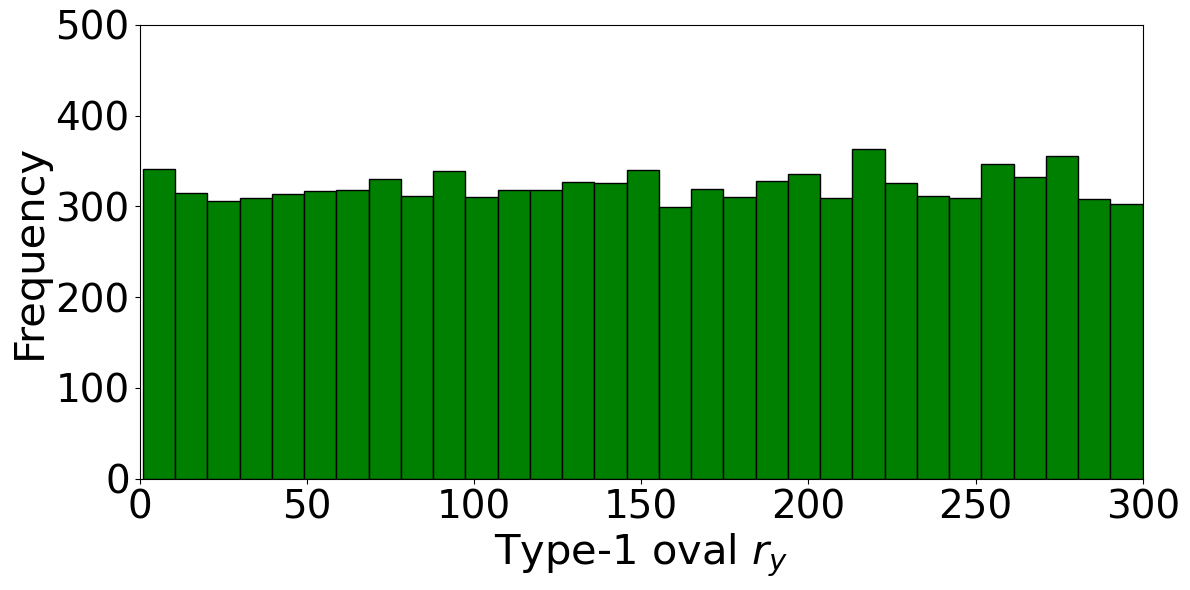

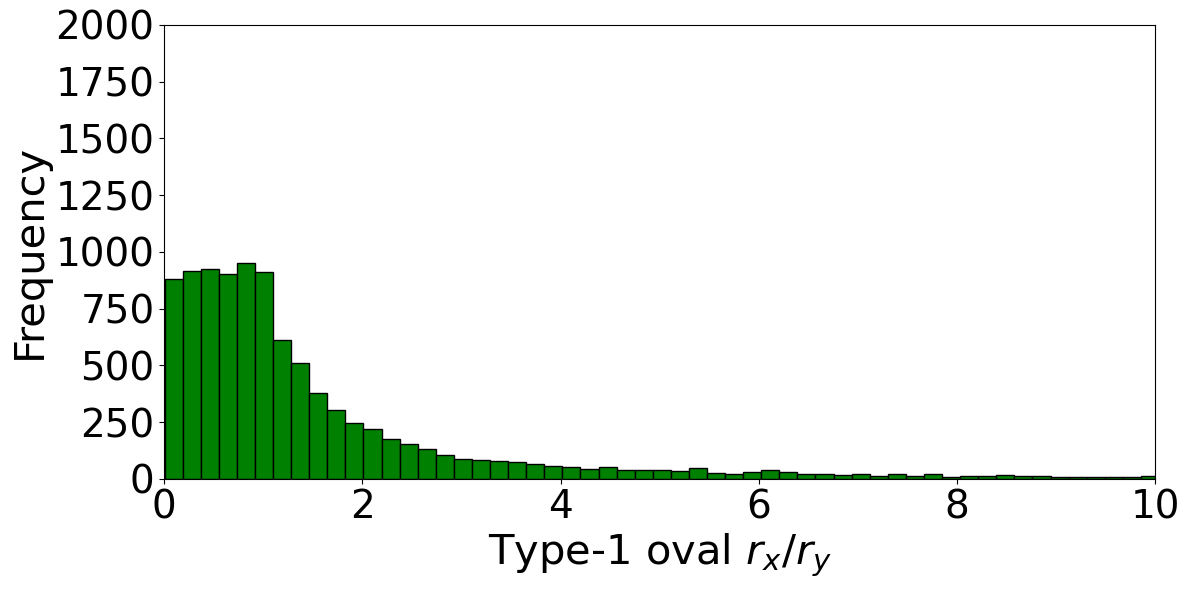

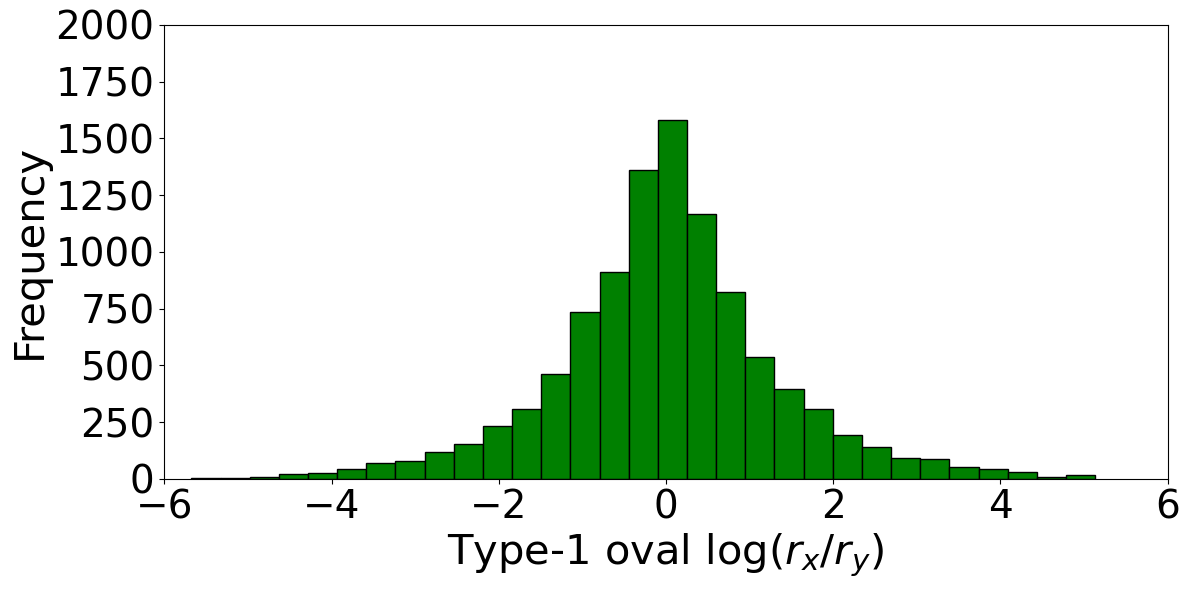

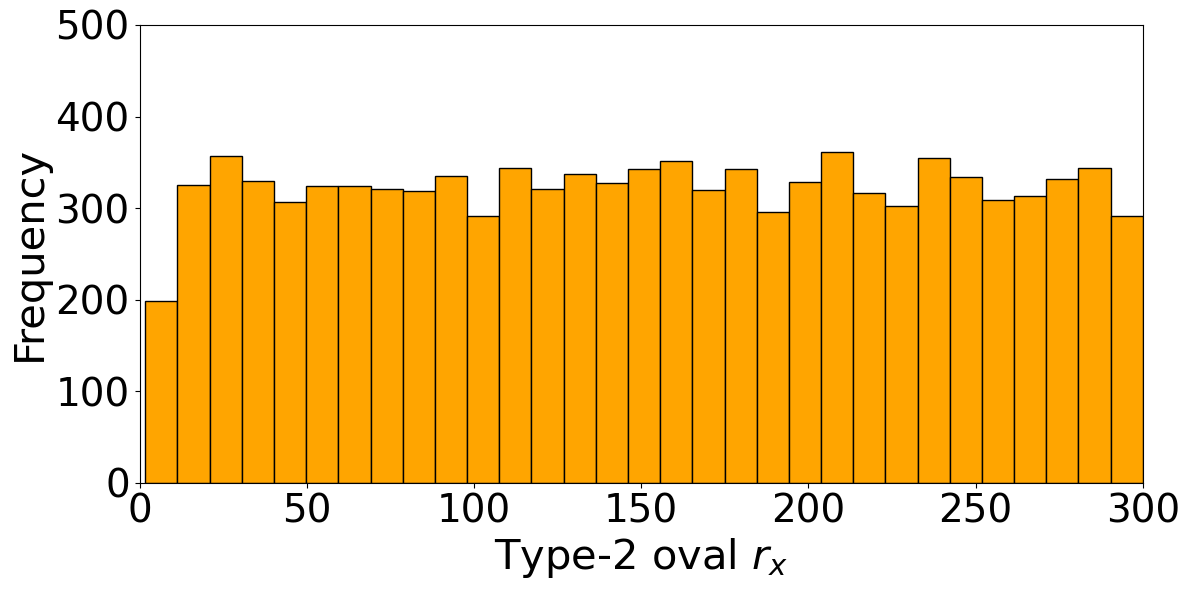

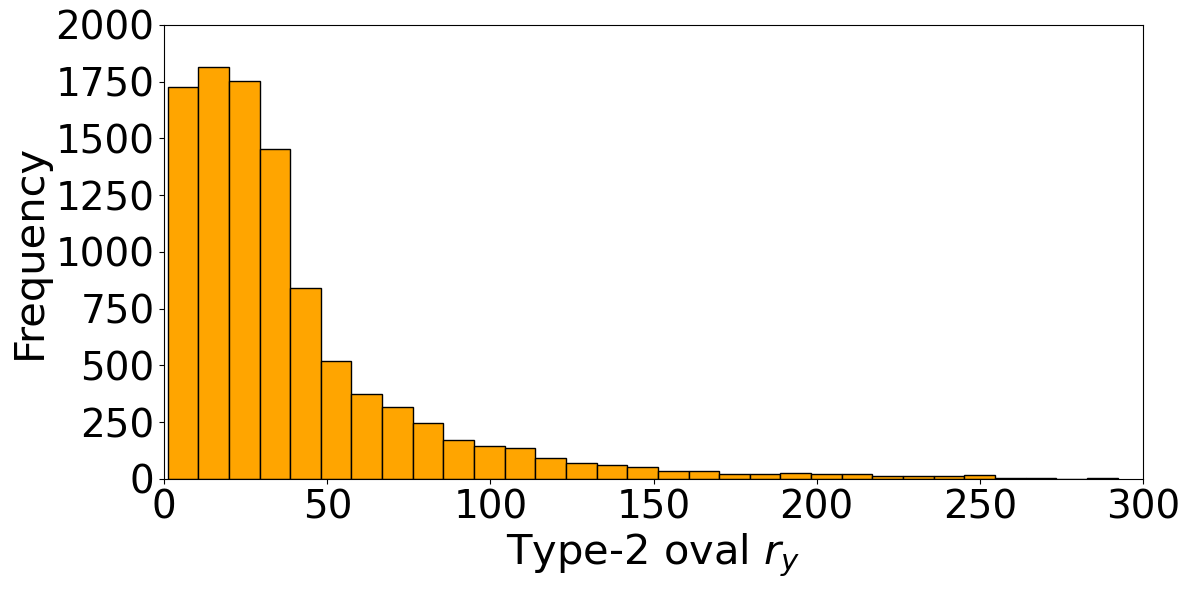

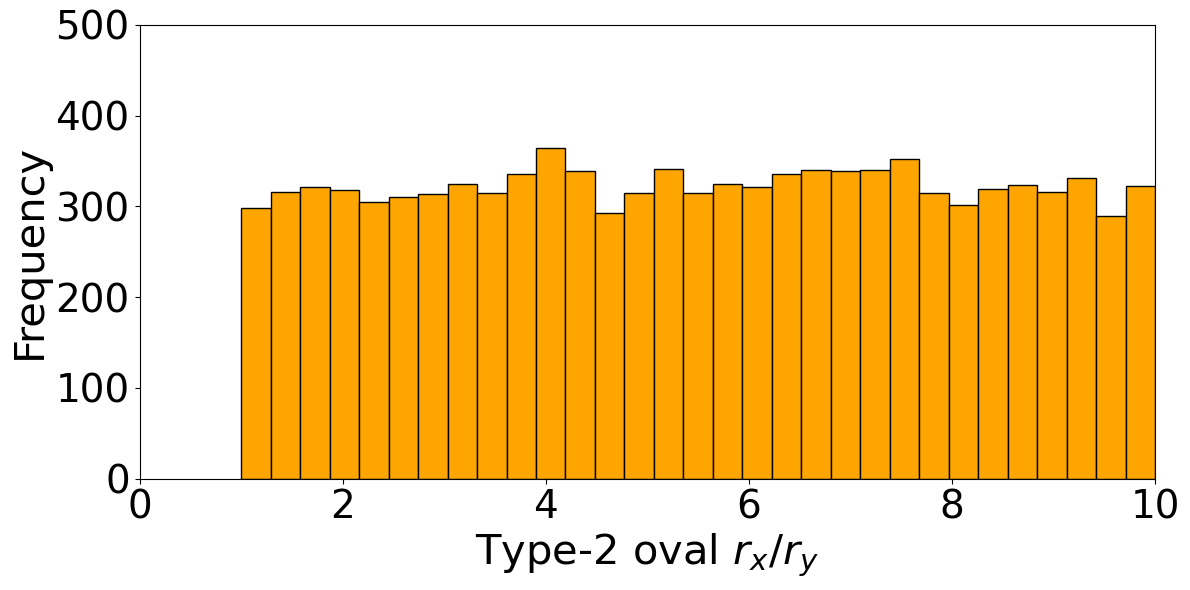

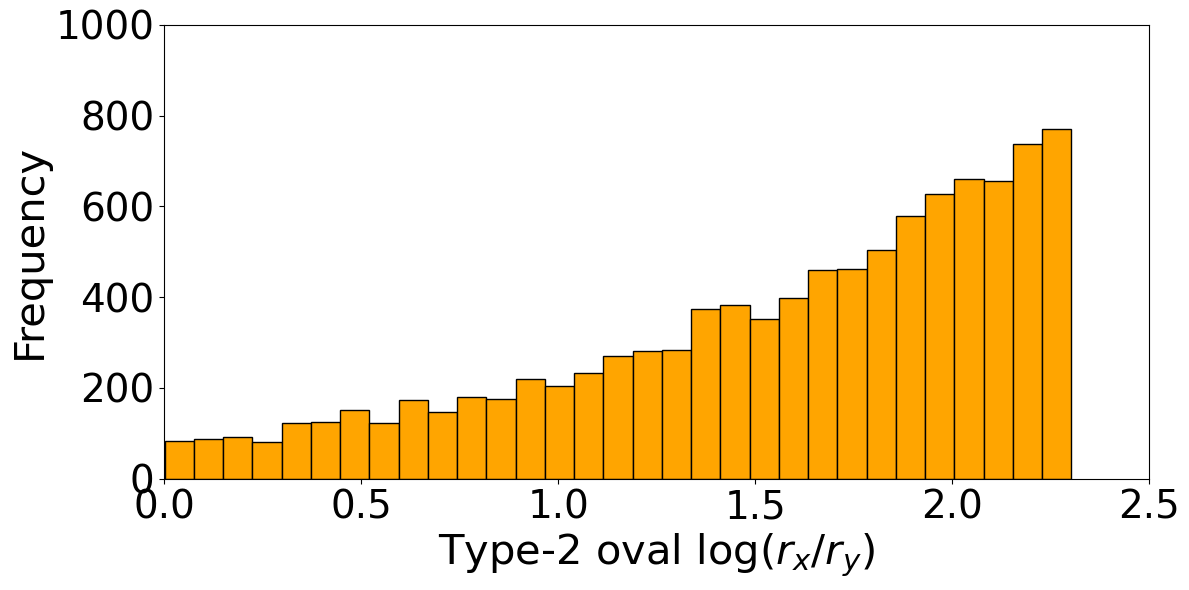

In [12]:
nrx,nry = sample_uniform_r_ovals2(10000,300)
rx,ry = sample_normal_r_ovals(10000,300)
plt.figure(figsize=(12,6))
plt.hist(rx,bins = int(3.3*np.log(len(rx))+1),edgecolor='black',color='green')
plt.xlabel(r"Type-1 oval $r_x$", fontsize = 30)
plt.ylabel("Frequency", fontsize = 30)
plt.xticks(fontsize=28)
plt.xlim(0,300)
plt.ylim(0,500)
plt.yticks(fontsize=28)
plt.tight_layout()
plt.savefig("type1rx.png")
plt.show()

plt.figure(figsize=(12,6))
plt.hist(ry,bins = int(3.3*np.log(len(ry))+1),edgecolor='black',color='green')
plt.xlabel(r"Type-1 oval $r_y$", fontsize = 30)
plt.ylabel("Frequency", fontsize = 30)
plt.xticks(fontsize=28)
plt.xlim(0,300)
plt.ylim(0,500)
plt.yticks(fontsize=28)
plt.tight_layout()
plt.savefig("type1ry.png")
plt.show()

plt.figure(figsize=(12,6))
plt.hist(rx/ry,bins = int(3.3*np.log(len(rx))+1)*30,edgecolor='black',color='green')
plt.xlabel(r"Type-1 oval $r_x/r_y$", fontsize = 30)
plt.ylabel("Frequency", fontsize = 30)
plt.xticks(fontsize=28)
plt.xlim(0,10)
plt.ylim(0,2000)
plt.yticks(fontsize=28)
plt.tight_layout()
plt.savefig("type1rxry.png")
plt.show()

plt.figure(figsize=(12,6))
plt.hist(np.log(rx/ry),bins = int(3.3*np.log(len(rx))+1),edgecolor='black',color='green')
plt.xlabel("Type-1 oval log($r_x/r_y$)", fontsize = 30)
plt.ylabel("Frequency", fontsize = 30)
plt.xticks(fontsize=28)
plt.xlim(-6,6)
plt.ylim(0,2000)
plt.yticks(fontsize=28)
plt.tight_layout()
plt.savefig("type1rxrylog.png")
plt.show()

plt.figure(figsize=(12,6))
plt.hist(nrx,bins = int(3.3*np.log(len(rx))+1),edgecolor='black',color='orange')
plt.xlabel(r"Type-2 oval $r_x$", fontsize = 30)
plt.ylabel("Frequency", fontsize = 30)
plt.xticks(fontsize=28)
plt.xlim(0,300)
plt.ylim(0,500)
plt.yticks(fontsize=28)
plt.tight_layout()
plt.savefig("type2rx.png")
plt.show()

plt.figure(figsize=(12,6))
plt.hist(nry,bins = int(3.3*np.log(len(ry))+1),edgecolor='black',color='orange')
plt.xlabel(r"Type-2 oval $r_y$", fontsize = 30)
plt.ylabel("Frequency", fontsize = 30)
plt.xticks(fontsize=28)
plt.xlim(0,300)
plt.ylim(0,2000)
plt.yticks(fontsize=28)
plt.tight_layout()
plt.savefig("type2ry.png")
plt.show()

plt.figure(figsize=(12,6))
plt.hist(nrx/nry,bins = int(3.3*np.log(len(rx))+1),edgecolor='black',color='orange')
plt.xlabel(r"Type-2 oval $r_x/r_y$", fontsize = 30)
plt.ylabel("Frequency", fontsize = 30)
plt.xticks(fontsize=28)
plt.xlim(0,10)
plt.ylim(0,500)
plt.yticks(fontsize=28)
plt.tight_layout()
plt.savefig("type2rxry.png")
plt.show()

plt.figure(figsize=(12,6))
plt.hist(np.log(nrx/nry),bins = int(3.3*np.log(len(rx))+1),edgecolor='black',color='orange')
plt.xlabel("Type-2 oval log($r_x/r_y$)", fontsize = 30)
plt.ylabel("Frequency", fontsize = 30)
plt.xticks(fontsize=28)
plt.xlim(0,2.5)
plt.ylim(0,1000)
plt.yticks(fontsize=28)
plt.tight_layout()
plt.savefig("type2rxrylog.png")
plt.show()